In [206]:
import json
import requests
import pandas as pd
import altair as alt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox  
import matplotlib.pyplot as plt
import seaborn as sns
alt.data_transformers.disable_max_rows() 

DataTransformerRegistry.enable('default')

# 1. Download data from the glassnode API & clean data

In [58]:
# insert your API key here
API_KEY = '28zG3XjYxPkTt9gF9cLUvOgFUWo'

df_list = [] 
# Get BTC closing price in USD (daily, from 2010-07-17 to today)
res = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',
    params={'a': 'BTC', 'api_key': API_KEY, 'i':'24h'}) # 
df = pd.read_json(res.text, convert_dates=['t']) 
df.rename({'v':'BTC price'},axis=1,inplace=True)
df_list.append( df )

# Get BTC Stock to Flow Ratio (daily, from 2010-07-17 to today)
res = requests.get('https://api.glassnode.com/v1/metrics/indicators/stock_to_flow_ratio',
    params={'a': 'BTC', 'api_key': API_KEY, 'i':'24h'}) # 
df = pd.read_json(res.text, convert_dates=['t']) 
#df.rename({'o':'BTC S2F'},axis=1,inplace=True)
df['BTC S2f'] = df['o'].apply(lambda x: x['ratio'])
df['BTC daysTillHalving'] = df['o'].apply(lambda x: x['daysTillHalving'])
df.drop(['o'], axis=1, inplace=True)
df_list.append( df )

# merge data
data_df = pd.merge( df_list[0], df_list[1], on='t', how='outer') 
data_df.rename({'t':'Date'}, axis=1, inplace=True)
data_df.head()

,t,BTC price,BTC S2f,BTC daysTillHalving
0,2010-07-17,0.049510,0.155814,865
1,2010-07-18,0.085840,0.155867,864
2,2010-07-19,0.080800,0.156621,863
3,2010-07-20,0.074733,0.157376,862
4,2010-07-21,0.079210,0.158258,861


# 2. S2F

### (2.1) Test S2F


In [122]:
# Figure 1

df = data_df[['Date', 'BTC price', 'BTC S2f', 'BTC daysTillHalving']].copy()
#df.dropna(inplace=True)
alt.Chart(df).transform_fold(
    ['BTC price', 'BTC S2f', 'BTC daysTillHalving'],
    as_ =['name','value']
).mark_line(
    tooltip=alt.TooltipContent('encoding')
).encode(
    x = 'Date',
    y = alt.Y('value:Q', scale=alt.Scale(type='log')),
    color = 'name:N',
    strokeDash ='name:N'
).properties(
    title = 'Figure1: BTC Price and BTC S2F (log y-axis)', 
    width=900,
    height=500
)

alt.Chart(...)

In [160]:
# Figure 2

df = data_df[['Date', 'BTC price', 'BTC S2f']].copy()
df[['BTC price', 'BTC S2f']] = df[['BTC price', 'BTC S2f']].apply(lambda x: np.log(x/x.shift(1))).cumsum()
#df.dropna(inplace=True)
alt.Chart(df).transform_fold(
    ['BTC price', 'BTC S2f'],
    as_ =['name','value']
).mark_line(
    tooltip=alt.TooltipContent('encoding'),
    opacity =0.8
).encode(
    x = 'Date',
    y = alt.Y('value:Q'),
    color = 'name:N',
    strokeDash ='name:N'
).properties(
    title = 'Figure1: BTC Price and BTC S2F (ln y-axis)', 
    width=900,
    height=500
)

alt.Chart(...)

In [161]:
# Test:
#   H0: BTC price = f(S2F) + v, Bitcoin's value is a function of Bitcoin's Stock-to-Flow
#   H1: Bitcoin's value is not a function of Bitcoin's Stock-to-Flow 
#spector_data.exog
#spector_data.endog
print( "ln(BTC Price) = a + b * ln(BTC s2f) + e")
df = data_df.dropna().copy()
x = sm.add_constant( np.log( df[['BTC S2f']]), prepend=False )
y = np.log(df[['BTC price']] )
model = sm.OLS(y, x).fit()
residual_df = pd.DataFrame(model.resid).rename({0:'residual'},axis=1)
residual_df['Date'] = df['Date'].values
print(model.summary())

ln(BTC Price) = a + b * ln(BTC s2f) + e
                            OLS Regression Results                            
Dep. Variable:              BTC price   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 9.756e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        17:29:29   Log-Likelihood:                -4597.7
No. Observations:                4331   AIC:                             9199.
Df Residuals:                    4329   BIC:                             9212.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BTC S2f     

In [172]:
# Figure 2

df = residual_df.copy()
#df['residual'] = df['residual'].cumsum()
alt.Chart(df).transform_fold(
    ['residual'],
    as_ =['name','value']
).mark_line(
    tooltip=alt.TooltipContent('encoding'),
    opacity =0.8
).encode(
    x = 'Date',
    y = alt.Y('value:Q'),
    color = 'name:N',
    strokeDash ='name:N'
).properties(
    title = 'Figure1: the residual of model: ln(BTC Price) = a + b * ln(BTC S2F) + e', 
    width=900,
    height=500
)

alt.Chart(...)

In [222]:
# white noise test 
print('''
H0:  it is white noise test 

And, We reject H0
''')
p_value = acorr_ljungbox(residual_df['residual'], lags=[14, 14*2, 14*3, 14*4, 14*6]) 
p_value


H0:  it is white noise test 

And, We reject H0



,lb_stat,lb_pvalue
14,57178.316321,0.0
28,106655.449661,0.0
42,147475.277255,0.0
56,179731.081792,0.0
84,223167.100377,0.0


left: [0, 1500]; mid:[1500,3000]; right:[3000, 4331]
left: [0, 2014-08-25 00:00:00]; mid:[2014-08-25 00:00:00,2018-10-03 00:00:00]; right:[2018-10-03 00:00:00, 4331]


1. The error series is changing, less volatility, more balanced
2. It's not white noise, and there are two kinds of powers in the BTC market
3. The error series flows AR(2), historical price information has strong impact on the price
4. What is ln(P)?  (a) Basically still Price  (b) Accumulate Continuous Return



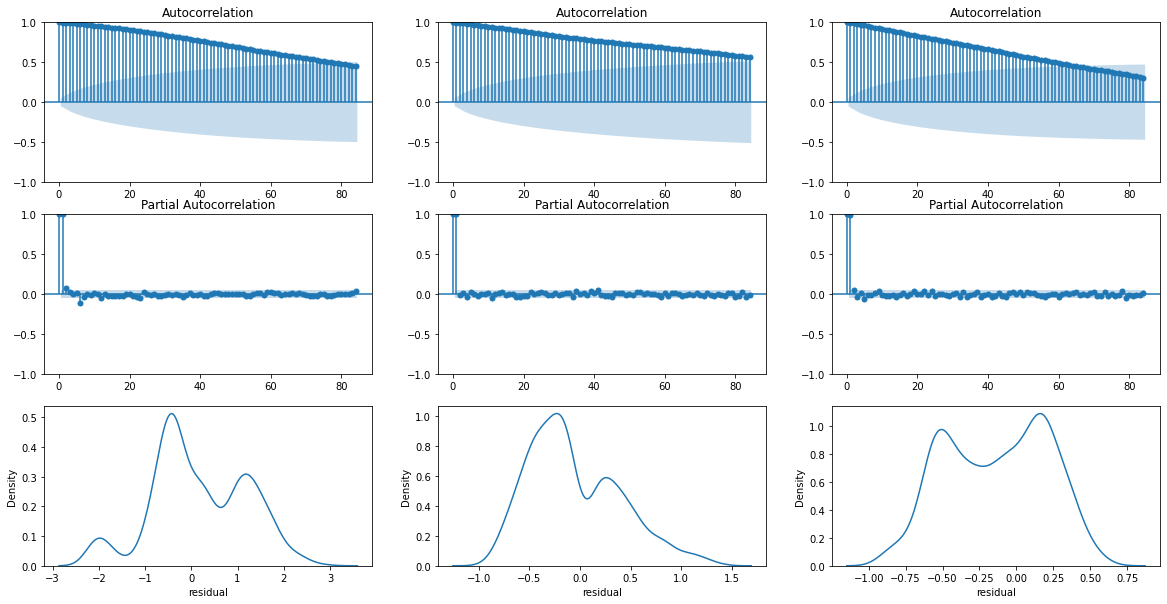

In [246]:
#acf 

bp_1 = 1500
bp_2 = 3000

fig, ax = plt.subplots(3,3,figsize=(20,10))

# [0:bp1]
sm.graphics.tsa.plot_acf(residual_df['residual'][:bp_1], lags=14*6, ax=ax[0,0]) # acf
sm.graphics.tsa.plot_pacf(residual_df['residual'][:bp_1], lags=14*6, method='ywm', ax=ax[1,0]) #pacf
sns.kdeplot(residual_df['residual'][:bp_1], ax= ax[2,0]) # distribution

# [bp1:bp2]
sm.graphics.tsa.plot_acf(residual_df['residual'][bp_1:bp_2], lags=14*6, ax=ax[0,1]) # acf
sm.graphics.tsa.plot_pacf(residual_df['residual'][bp_1:bp_2], lags=14*6, method='ywm', ax=ax[1,1]) #pacf
sns.kdeplot(residual_df['residual'][bp_1:bp_2], ax= ax[2,1]) # distribution

# [bp2:]
sm.graphics.tsa.plot_acf(residual_df['residual'][bp_2:], lags=14*6, ax=ax[0,2]) # acf
sm.graphics.tsa.plot_pacf(residual_df['residual'][bp_2:], lags=14*6, method='ywm', ax=ax[1,2]) #pacf
sns.kdeplot(residual_df['residual'][bp_2:], ax= ax[2,2]) # distribution

print(f'''left: [0, {bp_1}]; mid:[{bp_1},{bp_2}]; right:[{bp_2}, {len(residual_df['residual'])}]''')
print(f'''left: [0, {residual_df['Date'][bp_1]}]; mid:[{residual_df['Date'][bp_1]},{residual_df['Date'][bp_2]}]; right:[{residual_df['Date'][bp_2]}, {len(residual_df['residual'])}]''')
print()
print(f'''
1. The error series is changing, less volatility, more balanced
2. It's not white noise, and there are two kinds of powers in the BTC market
3. The error series flows AR(2), historical price information has strong impact on the price
4. What is ln(P)?  (a) Basically still Price  (b) Accumulate Continuous Return
'''
)
plt.show()

In [247]:
pd.concat([
    residual_df['residual'][:bp_1].describe(),
    residual_df['residual'][bp_1:bp_2].describe(),
    residual_df['residual'][bp_2:].describe()],
axis=1)

,residual,residual,residual
count,1500.000000,1500.000000,1331.000000
mean,0.169248,-0.051243,-0.132989
std,1.026029,0.455654,0.346403
min,-2.149250,-0.937386,-0.902357
25%,-0.493371,-0.400469,-0.453709
50%,0.030542,-0.149507,-0.100539
75%,1.050669,0.266416,0.159479
max,2.880199,1.375965,0.625585
